In [1]:
# import packages
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math as m
%matplotlib inline 

# Data pre-processing

In [2]:
# read historical data
cac40 = pd.read_csv('CAC 40 Historical Data_10yr.csv')
estx50 = pd.read_csv('Euro Stoxx 50 Historical Data_10yr.csv')

In [3]:
# keep only shared dates
cac40_dates = pd.Index(cac40.Date)
estx50_dates = pd.Index(estx50.Date)
shared_dates = cac40_dates.intersection(estx50_dates)
cac40 = cac40[cac40.Date.isin(shared_dates)]
estx50 = estx50[estx50.Date.isin(shared_dates)]
len(cac40) == len(estx50)

# format dates to datetime and set as index
cac40.Date = pd.to_datetime(cac40.Date)
estx50.Date = pd.to_datetime(estx50.Date)
cac40.set_index(['Date'], inplace=True)
estx50.set_index(['Date'], inplace=True)

# format as floats
cac40.Price = cac40.Price.str.replace(',', '')
cac40.Price = cac40.Price.astype(float)
estx50.Price = estx50.Price.str.replace(',', '')
estx50.Price = estx50.Price.astype(float)

# merge into one df
hist = pd.concat([cac40.Price, estx50.Price], keys=['CAC40', 'ESTX50'], axis=1)
hist.sort_index(inplace=True)

# add beta
hist['beta'] = (hist.CAC40 / hist.ESTX50)
hist['beta_SMA'] = hist.beta.rolling(window=5).mean()

In [4]:
EUR=hist['ESTX50']
CAC=hist['CAC40']
t0=0
t1=len(EUR)
EUR=EUR[t0:t1]
CAC=CAC[t0:t1]

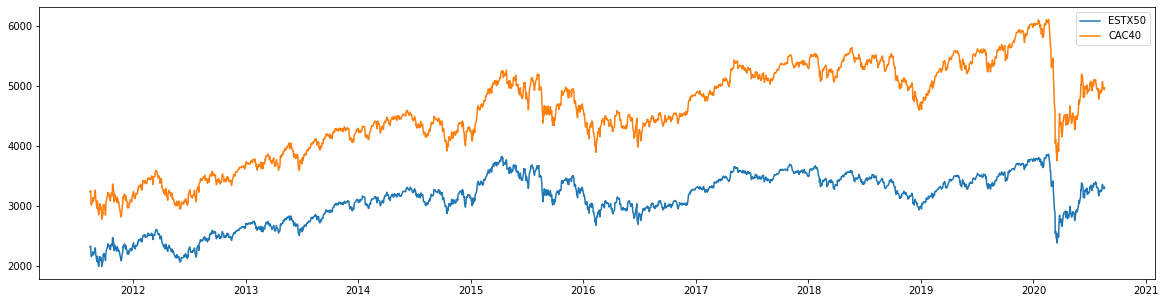

In [5]:
#visualise the prices
plt.figure(figsize=(20,5))
plt.plot(EUR, label='ESTX50')
plt.plot(CAC, label='CAC40')
plt.legend()


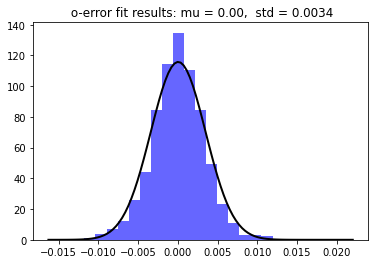

In [6]:
B=[] #list to store hedge ratio observations B(t) = CAC(t)/EUR(t)
for i in range(0,len(CAC)):
    B.append(CAC[i]/EUR[i])
    
B_diff=[] #stores the differences between consecutive hedge ratios, also observation of the error o ~ N(0,O)
for i in range(0,len(CAC)-1):
    B_diff.append(B[i+1]-B[i])

# Fit a normal distribution to the data:
mu, std = norm.fit(B_diff)

# Plot the histogram.
plt.hist(B_diff, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = " o-error fit results: mu = %.2f,  std = %.4f" % (mu, std)
plt.title(title)

plt.show()       


In [7]:
#we estimate Vyobs - observed variance
numbers = CAC
window_size = 30

i = 0
moving_averages = []
while i < len(numbers) - window_size + 1:
    this_window = numbers[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1
first_element=moving_averages[0]    
for j in range(window_size-1):
    moving_averages.insert(0,first_element)

# simple moving average 
SMA=[]
window_size=30
for i in range(len(CAC)):
    if i < window_size:
        SMA.append(np.mean(CAC[0:i+1]))                
    else:
        SMA.append(np.mean(CAC[i-window_size:i+1]))    
Vyobs=SMA

# Trading model

We implement a pairs trading model: the two identified indices have a high historical correlation,
and this strategy assumes the correlation stays strong. In particular, when the two index prices diverge, 
we expect them to converge back together. In turn, we short the outperforming index and long the underperforming one, 
thus making a profit once the correlation is established again and the positions are closed.

To decide when the indices have sufficiently diverged, the predicted price is modelled as a linear function of the observed price, 
and a Kalman filter is implemented to identify when the hedge ratio is significantly different than expected.

In [8]:
def KalmanFilter(X0,Y0,b0,Vb0,Vyobs):

#Inputs: 
#Y0 - the vector containing price of one stock (observation variable) for the time window T
#X0 - the vector containing price of the other stock (measurement matrix)
#b0 - the previous estimate for the hedge ratio b
#Vb0 - covariance matrix for the hedge ratio b (b is just scalar, so Vb is too)

#Output:
#Tuple (b,Vb,e,Ve) where:
#b - the new estimate for hedge ratio
#Vb - new estimate for covariance of b
#e - the difference between Yobs and Yest (Y is the observation variable)
#Vyexp - Variance of expected price for Y

    X=np.mean(X0) #for the time window, we take price to be constant - mean of the price movement in this window
    Vx=np.var(X0) #variance of the price over this time window
    Yobs=np.mean(Y0) #observation variable
    #Vyobs=2500 #np.var(Y0)

    #we first find the first-guess prediction of the hedge ratio based on the previous time, using the state transition model
    b1 = b0 #we assume b follows a random walk, so prediction is the same
    Vb1 = Vb0 + std**2 #abs(np.random.normal(0,std))#Vw # we found before, by fitting normal to b difference the standard deviation std

    #we now predict the measurement we expect to see in the price, using the observation model
    Yexp = b1 * X #predicts the expected measurement
    Vyexp = X * Vb1 * np.transpose(X)+ Vyobs #Ve #updates the observation covariance

    #we now recieve the data (X and Yobs) 

    #we find the by-products, needed to make trading decisions - the error tells us if the spread has just gone too large
    e = Yobs - Yexp #error between observed and expected price 

    #we find the final estimates for b and its variance, for the next run of kalman filter
    K = Vb1 * np.transpose(X) * (Vyexp)**(-1) #kalman gain
    b = b1 + K * e #final estimate for b
    Vb = Vb1 - K * X * Vb1 #final estimate for variance of b

    return (b,Vb,e,Vyexp) #function returns tuple

In [9]:
T=1 #define the time window for which we wanna consider price constant and run Kalman filter
chunksCAC = [CAC[x:x+T] for x in range(0, len(CAC),T)] #price list divided into T-sized chunks for use in Kalman filter
chunksEUR = [EUR[x:x+T] for x in range(0, len(EUR),T)]
chunks_moving_averages=[moving_averages[x:x+T] for x in range(0,len(moving_averages),T)]

constCAC = [np.mean(chunksCAC[i]) for i in range(0,len(chunksCAC))] #we replace chunks with means of the chunks
constEUR = [np.mean(chunksEUR[i]) for i in range(0,len(chunksEUR))]
const_moving_averages=[np.mean(chunks_moving_averages[i]) for i in range(0,len(chunks_moving_averages))]

r=1

Error=[]
STD=[]
Bpred=[]
Bobs=[constCAC[i]/constEUR[i] for i in range(0,len(constCAC))]
b = Bobs[0] #initialise b
Vb = 0 #initialise Vb
col=[]
for i in range(0,len(chunksCAC)):
    result = KalmanFilter(chunksEUR[i],chunksCAC[i],b,Vb,const_moving_averages[i])
    b = result[0]
    Vb = result[1]
    e = result[2]
    Vyexp = result[3]
    Bpred.append(b)
    Error.append(e)
    stdy = r*m.sqrt(abs(Vyexp))
    STD.append(stdy)



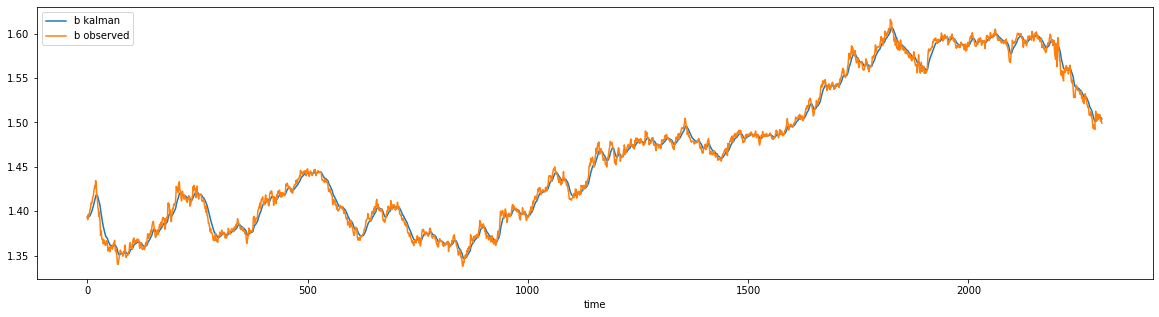

In [10]:
# plot hedge ratio observations vs predictions
plt.figure(figsize=(20,5))
plt.plot(Bpred,label='b kalman')
plt.plot(Bobs,label='b observed')
plt.xlabel('time')
plt.legend()


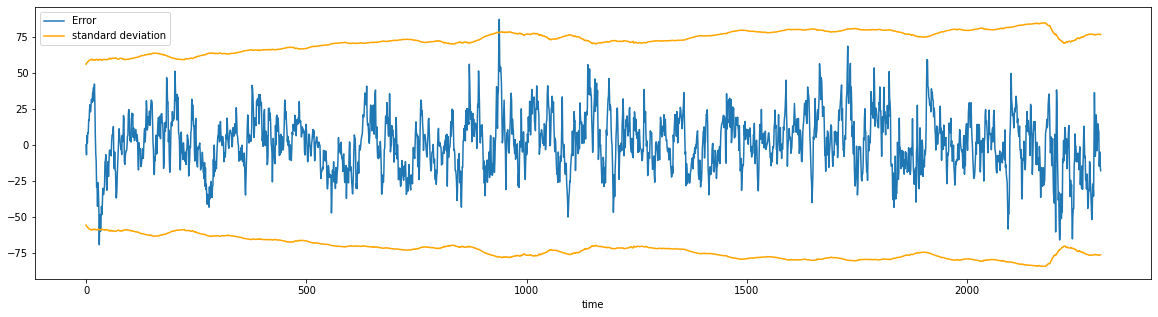

In [11]:
# trading signals
plt.figure(figsize=(20,5))
plt.plot(Error,label='Error')
plt.plot(STD,color='orange',label='standard deviation')
STDneg=[-i for i in STD]
plt.plot(STDneg,color='orange')
plt.xlabel('time')
plt.legend()


In [12]:
# trading rules
trad=['none']
current_position='neutral'
for i in range(1,len(STD)):
    if Error[i]>STD[i]:
        if current_position=='long':
            trad.append('exl')
            current_position='neutral'
        elif current_position=='neutral':
            trad.append('s')
            current_position='short'
        else: #if current_position='short'
            trad.append('none')
    elif Error[i]< -STD[i]:
        if current_position=='short':
            trad.append('exs')
            current_position='neutral'
        elif current_position=='neutral':
            trad.append('l')
            current_position='long'
        else: #if current_position='long'
            trad.append('none')
    else:
        trad.append('none')
trade=trad

In [13]:
# Colour red whenever we are shorting and green whenever we are longing
colours=[]
for i in range(len(trade)):
    colours.append(0)

i=0
while i!=len(colours)-1:
    if trade[i]=='s' or trade[i]=='exls':
        j=i
        while not (trade[j]=='exs' or trade[j]=='exsl' or j==len(colours)-1):
            colours[j]='r'
            j=j+1
        if trade[j]=='exsl':
            colours[j]='g'
        else:
            colours[j]='r'
    if trade[i]=='l' or trade[i]=='exsl':
        k=i
        while not (trade[k]=='exl' or trade[k]=='exls' or k==len(colours)-1):
            colours[k]='g'
            k=k+1
        if trade[k]=='exls':
            colours[k]='r'
        else:
            colours[k]='g'
    i=i+1

for l in range(len(colours)):
    if colours[l]==0:
        colours[l]='None'


# Backtesting

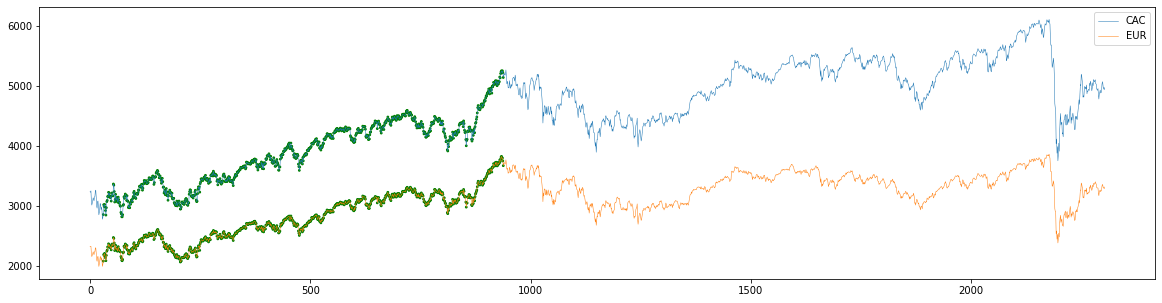

In [14]:
#visualise the trading action
x=range(len(colours))
plt.figure(figsize=(20,5))
plt.plot(x,constCAC,linewidth=0.5,label='CAC')
plt.plot(x,constEUR,linewidth=0.5,label='EUR')
plt.scatter(x,constEUR, color=colours, s=3)
plt.scatter(x,constCAC, color=colours, s=3)
plt.legend()

In [15]:
# calculate profit
X=constEUR
Y=constCAC
N=100 #number of shares we short or long
Investment=[]
Profit=[]
i=0
while i!=len(trade)-1:
    Nx=N
    Ny=m.floor(N*Bobs[i])
    if trade[i]=='s' or trade[i]=='exls':
        y_0=Y[i]
        x_0=X[i]
        j=i
        while not (trade[j]=='exs' or trade[j]=='exsl' or j==len(trade)-1):
            j=j+1
        y_1=Y[j]
        x_1=X[j]
        Profit.append(Ny*(y_0-y_1)+Nx*(-x_0+x_1))
        Investment.append(Ny*y_1+Nx*x_0)
    if trade[i]=='l' or trade[i]=='exsl':
        k=i
        y_0=Y[i]
        x_0=X[i]
        while not (trade[k]=='exl' or trade[k]=='exls' or k==len(trade)-1):
            k=k+1
        y_1=Y[k]
        x_1=X[k]
        Profit.append(Ny*(-y_0+y_1)+Nx*(x_0-x_1))
        Investment.append(Ny*y_0+Nx*x_1)
    i=i+1


print('profit: ',(sum(Profit)*100/sum(Investment)).round(3),'%')

profit:  20.263 %
